In [50]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import keras
import sentencepiece as spm

print(f"Keras version: {keras.__version__}")

Keras version: 2.15.0


In [51]:
# Cell 2: Load and prepare text data
with open('tekstit/satuteksti_plain.txt', 'r', encoding='utf-8-sig') as file:
    text = file.read()#.lower()

print(f"Text length: {len(text)} characters")
print(f"First 100 characters: {text[:100]}")

Text length: 74871 characters
First 100 characters: Suuressa kaupungissa, missä oli monta tornia ja kimaltelevaa
katonharjaa, asui kerran leipuri, jolla


In [52]:
# Cell 3: Train SentencePiece model
# Save text to a temporary file for SentencePiece training
temp_file = 'satuteksti_temp.txt'
with open(temp_file, 'w', encoding='utf-8') as f:
    f.write(text)

# Train SentencePiece model
vocab_size = 13000  # You can adjust this based on your needs
model_prefix = 'satuteksti_sp'

spm.SentencePieceTrainer.train(
    input=temp_file,
    model_prefix=model_prefix,
    vocab_size=vocab_size,
    character_coverage=1.0,  # Important for Finnish
    model_type='bpe',
    user_defined_symbols=['<PAD>', '<UNK>']
)

# Load the trained tokenizer
sp = spm.SentencePieceProcessor()
sp.load(f"{model_prefix}.model")

# Test tokenization
test_text = "Olipa kerran kettu"
tokens = sp.encode_as_pieces(test_text)
print(f"Tokenized example: {tokens}")
print(f"Vocabulary size: {sp.get_piece_size()}")

Tokenized example: ['▁Olipa', '▁kerran', '▁k', 'ettu']
Vocabulary size: 13000


In [53]:
# Cell 4: Prepare training data
# Tokenize the text
seq_length = 64
pieces = sp.encode_as_ids(text)
print(f"Total tokens: {len(pieces)}")

# Create sequences
sequences = []
for i in range(0, len(pieces) - seq_length):
    # Input: first seq_length tokens, Target: next seq_length tokens (shifted by 1)
    sequences.append(pieces[i:i+seq_length+1])

# Convert to NumPy arrays
sequences = np.array(sequences)
inputs = sequences[:, :-1]  # All tokens except the last one
targets = sequences[:, 1:]  # All tokens except the first one

print(f"Number of sequences: {len(sequences)}")
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")

# Split into training and validation sets
indices = np.arange(len(sequences))
np.random.shuffle(indices)

train_size = int(0.8 * len(sequences))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_inputs, train_targets = inputs[train_indices], targets[train_indices]
val_inputs, val_targets = inputs[val_indices], targets[val_indices]

Total tokens: 12472
Number of sequences: 12408
Input shape: (12408, 64)
Target shape: (12408, 64)


In [54]:
# Cell 5: Define the model
def get_positional_encoding(max_len, d_model):
    """Create sinusoidal positional encoding."""
    positions = np.arange(max_len)[:, np.newaxis]
    angles = np.arange(d_model)[np.newaxis, :] / d_model
    angles = 1 / (10000**angles)

    pos_encoding = positions * angles
    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])

    return pos_encoding

# Define model parameters
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 3

# Create the model
inputs = keras.Input(shape=(seq_length,))
embedding_layer = keras.layers.Embedding(sp.get_piece_size(), embed_dim)(inputs)

# Add positional encoding
pos_encoding = get_positional_encoding(seq_length, embed_dim)
x = embedding_layer + pos_encoding

# Helper function to create causal attention mask
def create_causal_mask(size):
    """Create a causal attention mask to prevent looking at future tokens."""
    mask = 1 - np.triu(np.ones((size, size)), k=1)
    return mask  # Lower triangular matrix

# Transformer blocks
for _ in range(num_layers):
    # Multi-head attention with causal mask
    # Manually create causal mask since use_causal_mask parameter isn't available
    causal_mask = create_causal_mask(seq_length)

    # Apply attention with manual causal mask
    attention_output = keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads
    )(x, x, attention_mask=causal_mask)

    # Add & Norm
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + attention_output)

    # Feed-forward network
    ffn = keras.Sequential([
        keras.layers.Dense(ff_dim, activation="relu"),
        keras.layers.Dense(embed_dim),
        keras.layers.Dropout(0.1)
    ])
    ffn_output = ffn(x)

    # Add & Norm
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

# Final output layer
outputs = keras.layers.Dense(sp.get_piece_size())(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 64, 256)              3328000   ['input_4[0][0]']             
                                                                                                  
 tf.__operators__.add_21 (T  (None, 64, 256)              0         ['embedding_3[0][0]']         
 FOpLambda)                                                                                       
                                                                                                  
 multi_head_attention_9 (Mu  (None, 64, 256)              263168    ['tf.__operators__.add_2

In [55]:
# Cell 6: Train the model
batch_size = 64
epochs = 10

history = model.fit(
    train_inputs, train_targets,
    validation_data=(val_inputs, val_targets),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1),
        keras.callbacks.ModelCheckpoint('satuteksti_best_model.keras', save_best_only=True)
    ]
)

Epoch 1/10
156/156 [==============================] - 141s 878ms/step - loss: 6.9978 - accuracy: 0.0992 - val_loss: 6.5972 - val_accuracy: 0.1002 - lr: 3.0000e-04
Epoch 2/10
156/156 [==============================] - 136s 871ms/step - loss: 6.5160 - accuracy: 0.1131 - val_loss: 5.9736 - val_accuracy: 0.2114 - lr: 3.0000e-04
Epoch 3/10
156/156 [==============================] - 136s 874ms/step - loss: 4.7823 - accuracy: 0.2756 - val_loss: 3.5800 - val_accuracy: 0.4145 - lr: 3.0000e-04
Epoch 4/10
156/156 [==============================] - 136s 875ms/step - loss: 2.7650 - accuracy: 0.5039 - val_loss: 2.0610 - val_accuracy: 0.5756 - lr: 3.0000e-04
Epoch 5/10
156/156 [==============================] - 137s 878ms/step - loss: 1.6157 - accuracy: 0.6722 - val_loss: 1.1273 - val_accuracy: 0.7758 - lr: 3.0000e-04
Epoch 6/10
156/156 [==============================] - 136s 875ms/step - loss: 0.8377 - accuracy: 0.8640 - val_loss: 0.4942 - val_accuracy: 0.9398 - lr: 3.0000e-04
Epoch 7/10
156/156 [==

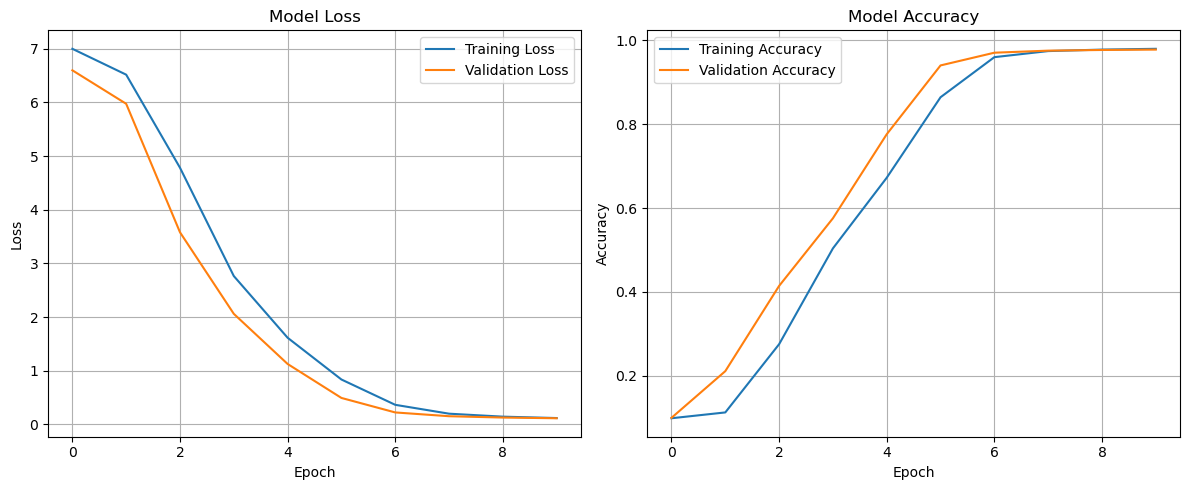

In [56]:
# Cell 7: Plot training metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
# Cell 8: Save the model
model.save('satuteksti_model.keras')
print("Model saved as 'satuteksti_model.keras'")

Model saved as 'satuteksti_model.keras'


In [58]:
def generate_text(model, sp, prompt, num_tokens=100, temperature=1.0):
    """Generate text based on a prompt with proper lowercase handling."""
    # Convert prompt to lowercase to match training data
    lowercase_prompt = prompt#.lower()

    # Encode the prompt
    input_ids = sp.encode_as_ids(lowercase_prompt)

    # Rest of your generation code stays the same...
    if len(input_ids) < seq_length:
        padding_length = seq_length - len(input_ids)
        input_ids = [0] * padding_length + input_ids
    else:
        padding_length = 0
        input_ids = input_ids[-seq_length:]

    # Generated tokens
    generated_ids = list(input_ids[padding_length:])

    # Generate text token by token
    for _ in range(num_tokens):
        x = np.array([input_ids])
        predictions = model.predict(x, verbose=0)[0]
        logits = predictions[-1]
        logits = logits / temperature
        exp_logits = np.exp(logits - np.max(logits))
        probs = exp_logits / np.sum(exp_logits)
        next_token = np.random.choice(len(probs), p=probs)
        generated_ids.append(next_token)
        input_ids = input_ids[1:] + [next_token]

    # Decode the generated sequence
    generated_text = sp.decode(generated_ids)

    return generated_text

In [62]:
# Cell 10: Generate sample text
prompts = [
    "Kerran käveli",
    "Olipa kerran",
    "surullinen kuningas",
    "iloinen neito"
]

for prompt in prompts:
    print(f"\nPrompt: {prompt}")
    generated = generate_text(model, sp, prompt, num_tokens=100, temperature=1.2)
    print(generated)


Prompt: Kerran käveli
Kerran käveli kät vahinko, mutta istuivat tahdon niin hyvä, ja kun se pystyi jospa hän ei kukaan tullut elämään, kaikui raikuva muuan iloinen räätälinsälli hänen kukkaroaan. Samassa oli hän jalkeilla. — Pidän. — suureen, joka voi hän tiesi, ettei Janek ollutkaan yksin. helmet olivat riekaleina, kengät lintassa, ja tukka kantta. Kuningas ei kukaan ollut kruunussa eilen, jos tuuli hiukan kääntyisi, ja Niilo ja Niilo kaulanauhan jalokivet säkenöimään. Se katsoi niin lämpöisesti ja ystävällisesti prinsessaan. — — Olet puettu kuin morsian, sanoi se, mutta onnelliselta

Prompt: Olipa kerran
Olipa kerran, syöksyy pohjatuuli luoksesi, jos olet kanssani samaa mieltä, pulskempia oli kyllä nähty, ei heillä oikeastaan helmensä sai, ei hän nähnyt. Näin ovi kuitenkin mitä ajatella ja varovasti kirkkaat tähtöset. MYLLYRENKI, JOKA SAI TAIVAAN TUULET VALTAANSA. Oli kerran myllyrenki, joka oli saanut päähänsä, että hän menisi naimisiin itse myllärin tyttären kanssa. Tyttö ei muuta